# Решение 1 соревнования по Машинному обучению

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn_pandas import DataFrameMapper

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder


from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

In [3]:
df_train = pd.read_csv('/kaggle/input/mts-teta-compet1/train.csv')
df_test = pd.read_csv('/kaggle/input/mts-teta-compet1/test.csv')

In [4]:
df_train

,client_id,регион,использование,сумма,частота_пополнения,доход,сегмент_arpu,частота,объем_данных,on_net,продукт_1,продукт_2,зона_1,зона_2,mrg_,секретный_скор,pack,pack_freq,binary_target
0,0,Уран,>24LY,14.617797,1.0,27034.974914,71.37,1.000000,NaN,26.0,10.0,NaN,NaN,NaN,False,0.540984,_output-_сеть 500 (условие) 2000f;5d,1.000000,0
1,1,Марс,>24LY,32.686083,3.0,40373.828300,354.27,2.000000,35.679126,45.0,8.0,NaN,NaN,NaN,False,0.573770,тариф_a 250 (условие) _безлим_c_output_сутки,1.414214,0
2,2,Церера,>24LY,25.318570,3.0,32004.378374,139.74,1.414214,NaN,NaN,13.0,NaN,NaN,NaN,False,0.131148,NaN,NaN,0
3,3,Марс,>24LY,70.710678,38.0,59953.505011,1722.65,6.403124,163.309522,203.0,274.0,NaN,NaN,0.031817,False,0.885246,"трафик: 100 (условие) 40mb,_сутки",4.000000,0
4,4,Меркурий,>24LY,9.244999,2.0,21499.998428,28.63,1.414214,5.000000,NaN,NaN,NaN,NaN,NaN,False,0.344262,"трафик: 100 (условие) 40mb,_сутки",1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010243,1010243,Марс,>24LY,73.088166,19.0,57900.865741,1498.72,4.582576,NaN,80.0,258.0,2.0,NaN,NaN,False,0.934426,_output-_сеть 500 (условие) 2000f;5d,4.242641,0
1010244,1010244,Марс,>24LY,20.672445,2.0,32166.158933,142.74,2.645751,NaN,25.0,2.0,5.0,NaN,NaN,False,0.540984,_output-_сеть 500 (условие) 2000f;5d,1.000000,0
1010245,1010245,Земля,>24LY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.049180,NaN,NaN,1
1010246,1010246,Солнце,>24LY,66.986417,10.0,56223.620819,1332.48,4.123106,NaN,62.0,31.0,29.0,NaN,NaN,False,1.000000,_соц_u2opia_weekly,1.000000,0


## Data Preparation

In [90]:
def data_prepare(data):
    data_clean = data.copy()
#     data_clean['зона_1'] = data_clean['зона_1'].fillna(0)
#     data_clean['зона_2'] = data_clean['зона_2'].fillna(0)
    
    
    data_clean['зона_1_cat'] = data['зона_1'].apply(lambda x: 0 if np.isnan(x) or x==0 else 1)
    data_clean['зона_2_cat'] = data['зона_2'].apply(lambda x: 0 if np.isnan(x) or x==0 else 1)
    
    pie_vals_dependents = list(zip(data['pack'].value_counts().index, round(data['pack'].value_counts(normalize=True) * 100, 2).values))
    list2replace = [i[0] for i in pie_vals_dependents if i[1]<2]
    data_clean['pack_prepared'] = data['pack'].apply(lambda x: 'others' if x in list2replace or pd.isnull(x) else x)
    
    
    data_clean['использование_prepared'] = data['использование'].apply(lambda x: 1 if x == '>24LY' else 0)
    
    data_clean['регион_prepared'] = data['регион'].apply(lambda x: 'others' if pd.isnull(x) else x)
    
    data_clean['missing_values_count'] = data.isnull().sum(axis=1)
    
#     data_clean['секретный_скор_bin'] = pd.cut(data['секретный_скор'], bins=bins, labels=labels)
    
#     data_clean['nan_in_sum'] = data_clean['сумма'].apply(lambda x: 0 if np.isnan(x) else 1)
    
    return data_clean

In [92]:
clean_data = data_prepare(df_train)

In [ ]:
clean_data['pack_prepared'].nunique()

In [93]:
clean_data.columns

Index(['client_id', 'регион', 'использование', 'сумма', 'частота_пополнения',
       'доход', 'сегмент_arpu', 'частота', 'объем_данных', 'on_net',
       'продукт_1', 'продукт_2', 'зона_1', 'зона_2', 'mrg_', 'секретный_скор',
       'pack', 'pack_freq', 'binary_target', 'зона_1_cat', 'зона_2_cat',
       'pack_prepared', 'использование_prepared', 'регион_prepared',
       'missing_values_count'],
      dtype='object')

In [94]:
num_cols = [
    'сумма',
    'частота_пополнения',
    'доход',
    'сегмент_arpu',
    'частота',
    'объем_данных',
    'on_net',
    'продукт_1',
    'продукт_2',
    'зона_1',
    'зона_2',
    'секретный_скор',
    'pack_freq',
    'missing_values_count',
]

cat_cols = [
    'зона_1_cat',
    'зона_2_cat',
    'регион_prepared',
    'использование_prepared',
    'pack_prepared',
]

feature_cols = num_cols + cat_cols
target_col = 'binary_target'

<Axes: >

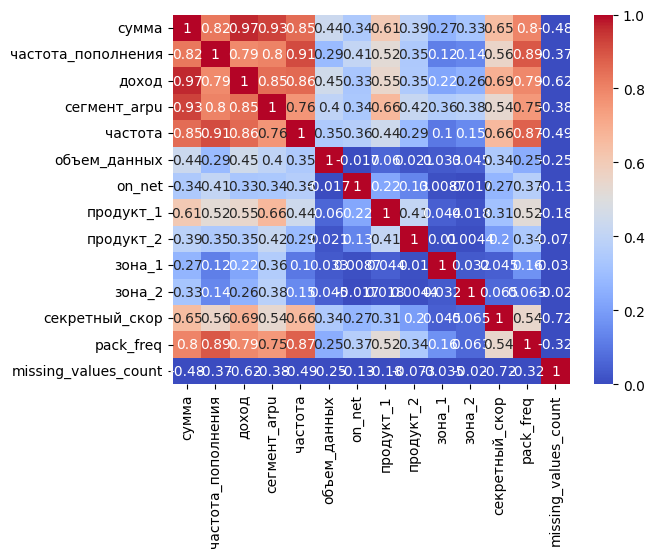

In [95]:
correlation_matrix = clean_data[num_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)

In [96]:
X = clean_data[feature_cols]
y = clean_data[target_col]

In [97]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010248 entries, 0 to 1010247
Data columns (total 19 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   сумма                   655354 non-null   float64
 1   частота_пополнения      655354 non-null   float64
 2   доход                   669787 non-null   float64
 3   сегмент_arpu            669787 non-null   float64
 4   частота                 669787 non-null   float64
 5   объем_данных            512886 non-null   float64
 6   on_net                  641315 non-null   float64
 7   продукт_1               590287 non-null   float64
 8   продукт_2               405005 non-null   float64
 9   зона_1                  79807 non-null    float64
 10  зона_2                  64000 non-null    float64
 11  секретный_скор          1010248 non-null  float64
 12  pack_freq               586973 non-null   float64
 13  missing_values_count    1010248 non-null  int64  
 14  зо

## Построение моделей

### CatBoost

In [98]:
catboost = CatBoostClassifier(
    cat_features=cat_cols,
    logging_level="Silent",
    eval_metric="AUC:hints=skip_train~false",
    grow_policy="Lossguide",
    metric_period=1000,
    task_type="GPU",
    devices='0:1'
)


PARAMS = {    
    'l2_leaf_reg': [10], #[1,5,10,100],
    'iterations':[1000], #[100, 200, 300, 500, 700, 1000],
    "learning_rate": [0.03], #[0.001,0.01, 0.03], 
    "max_depth": [5], #np.arange(2, 6, 1),
}

catboost.grid_search(PARAMS, X, y, cv=5, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.9042261	best: 0.9042261 (0)	total: 32s	remaining: 0us
Estimating final quality...


{'params': {'depth': 5,
  'learning_rate': 0.03,
  'l2_leaf_reg': 10,
  'iterations': 1000},
 'cv_results': defaultdict(list,
             {'iterations': [0, 999],
              'test-AUC-mean': [0.897542679309845, 0.9030950665473938],
              'test-AUC-std': [0.0013172743004395838, 0.0011194214126023874],
              'train-AUC-mean': [0.8977081656455994, 0.9055055260658265],
              'train-AUC-std': [0.0006946220257349485, 0.0002729940578312588],
              'test-Logloss-mean': [0.6561532883985928, 0.2932361798780275],
              'test-Logloss-std': [0.00039941955255910934,
               0.001412267863169651],
              'train-Logloss-mean': [0.656145817548808, 0.29024092343852653],
              'train-Logloss-std': [0.0003915091177054464,
               0.00034932424984380784]})}

In [99]:
f1_score(catboost.predict(X), y)


0.6082627653371163

In [100]:
def find_optimal_threshold(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)  # Генерируем 100 равномерно распределенных порогов от 0 до 1
    best_threshold = None
    best_f1 = -1

    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)  # Преобразуем вероятности в бинарные предсказания по порогу
        f1 = f1_score(y_true, y_pred)  # Вычисляем F1-меру для текущего порога

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1



In [101]:
# Пример использования:
# y_true - истинные метки классов
# y_pred_proba - вероятности принадлежности к классу 1

optimal_threshold, max_f1 = find_optimal_threshold(y, catboost.predict_proba(X)[:, 1])
print("Оптимальный порог:", optimal_threshold)
print("Максимальное значение F1-меры:", max_f1)

Оптимальный порог: 0.33333333333333337
Максимальное значение F1-меры: 0.6539438488692851


In [102]:
# df_test['секретный_скор_bin'] = pd.cut(df_test['секретный_скор'], bins=bins, labels=labels)
test_clean = data_prepare(df_test)

In [103]:
X_test = test_clean[feature_cols]

In [104]:
X_test

,сумма,частота_пополнения,доход,сегмент_arpu,частота,объем_данных,on_net,продукт_1,продукт_2,зона_1,зона_2,секретный_скор,pack_freq,missing_values_count,зона_1_cat,зона_2_cat,регион_prepared,использование_prepared,pack_prepared
0,9.244999,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.081967,NaN,11,0,0,Нептун,1,others
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.262295,NaN,13,0,0,Земля,1,others
2,18.489997,3.0,30424.692691,114.10,1.732051,1.000000,22.0,13.0,NaN,0.000835,NaN,0.934426,1.000000,2,1,0,Марс,1,_output-_сеть 500 (условие) 2000f;5d
3,39.223207,7.0,44284.990356,512.82,2.645751,7.615773,130.0,123.0,5.0,NaN,NaN,0.508197,2.236068,3,0,0,others,1,_output-_сеть 500 (условие) 2000f;5d
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.163934,NaN,13,0,0,Сатурн,1,others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497581,54.694150,14.0,52294.430677,997.01,3.741657,NaN,147.0,207.0,36.0,NaN,NaN,1.000000,3.741657,3,0,0,Марс,1,тариф_a:500 (условие) 2500f input__ _сеть _250...
497582,9.244999,1.0,14723.954424,6.41,1.414214,NaN,266.0,24.0,NaN,NaN,NaN,0.721311,NaN,6,0,0,Марс,1,others
497583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016393,NaN,14,0,0,others,1,others
497584,28.867456,5.0,37991.746291,277.78,2.236068,0.000000,23.0,30.0,NaN,NaN,NaN,0.459016,1.414214,3,0,0,Марс,1,_output-_сеть 500f =2000f__output_сеть__безлим


In [105]:
submission = pd.read_csv('/kaggle/input/mts-teta-compet1/sample_submission.csv')
submission["preds"] = catboost.predict_proba(X_test)[:,1]
submission["preds"] = submission["preds"].apply(lambda x: 1 if x > optimal_threshold else 0)
submission.to_csv("/kaggle/working/catboost_with_DataPreparation_final_8.csv", index=False)

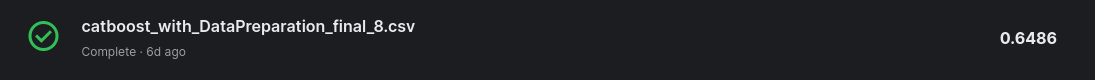

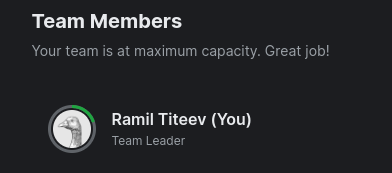